# Cell Clustering

Like in previous examples, we have been interested in the clustering of cells. We will continue on this path but instead of computing autocorrelations or other fancy metrics, we wil just directly cluster the cells without some proxy metric. Like previously, we will be looking at the distances of the clusters to regions of interest.

In this notebook, we will demonstrate how to cluster immune cells in a nuclei segmentation mask.

## The Data

The data used in this example is a cervical pre-cancerous biopsy. The data is not publicly available, so this serves only as a demonstration of `cellseg_gsontools` functionality.

In [1]:
from pathlib import Path
from cellseg_gsontools import read_gdf

tissue_path = Path("/path/to/tissues.geojson")
nuc_path = Path("/path/to/nuclei.geojson")

tissues = read_gdf(tissue_path)[["geometry", "class_name"]] # take only relevant columns
nuclei = read_gdf(nuc_path)[["geometry", "class_name"]]

tissues.head(5)

,geometry,class_name
0,"POLYGON ((15254.29000 111406.03000, 15249.5200...",areastroma
1,"POLYGON ((13930.07000 104644.52000, 13930.0300...",areastroma
2,"POLYGON ((13980.29000 104162.03000, 13976.5200...",areastroma
3,"POLYGON ((12774.89000 109112.00000, 12771.5200...",areastroma
4,"POLYGON ((11829.07000 103235.52000, 11829.0000...",areastroma


<Axes: >

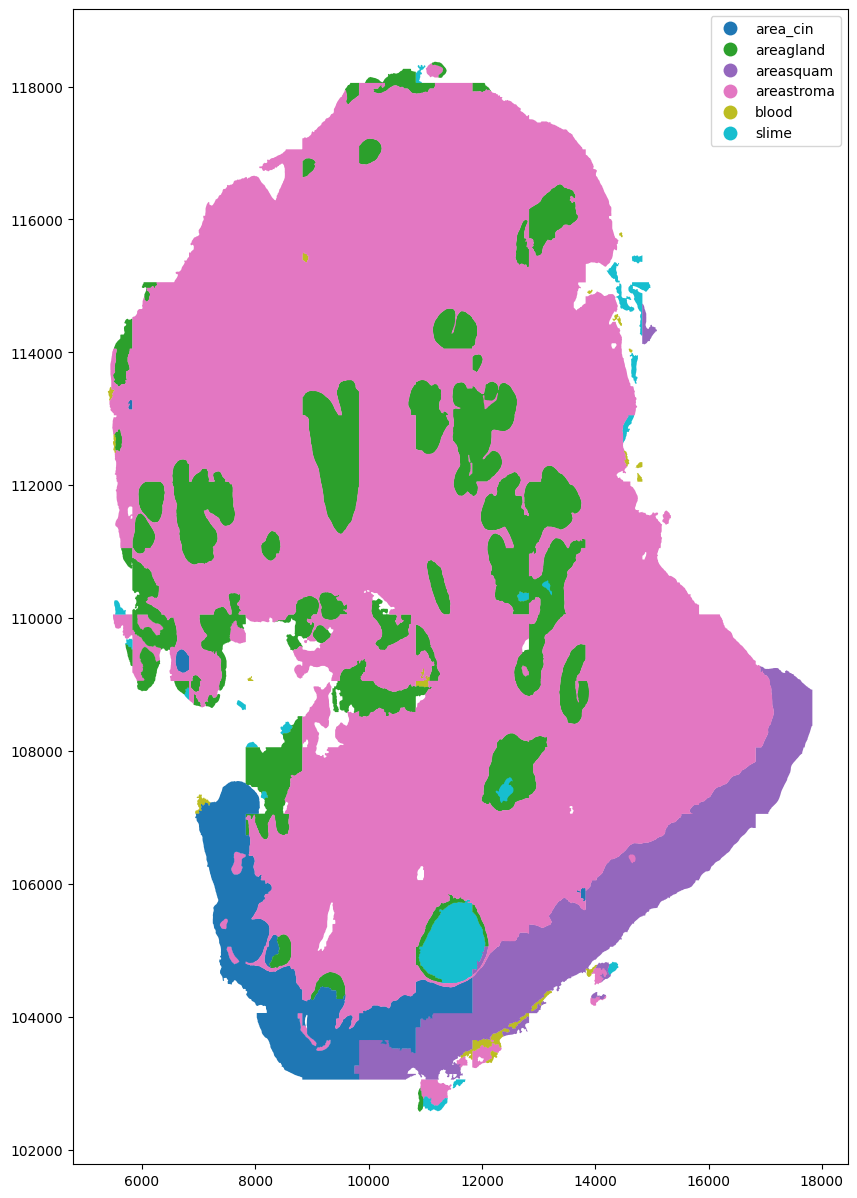

In [2]:
tissues.plot(figsize=(10, 15), column="class_name", legend=True, aspect=None)

<Axes: >

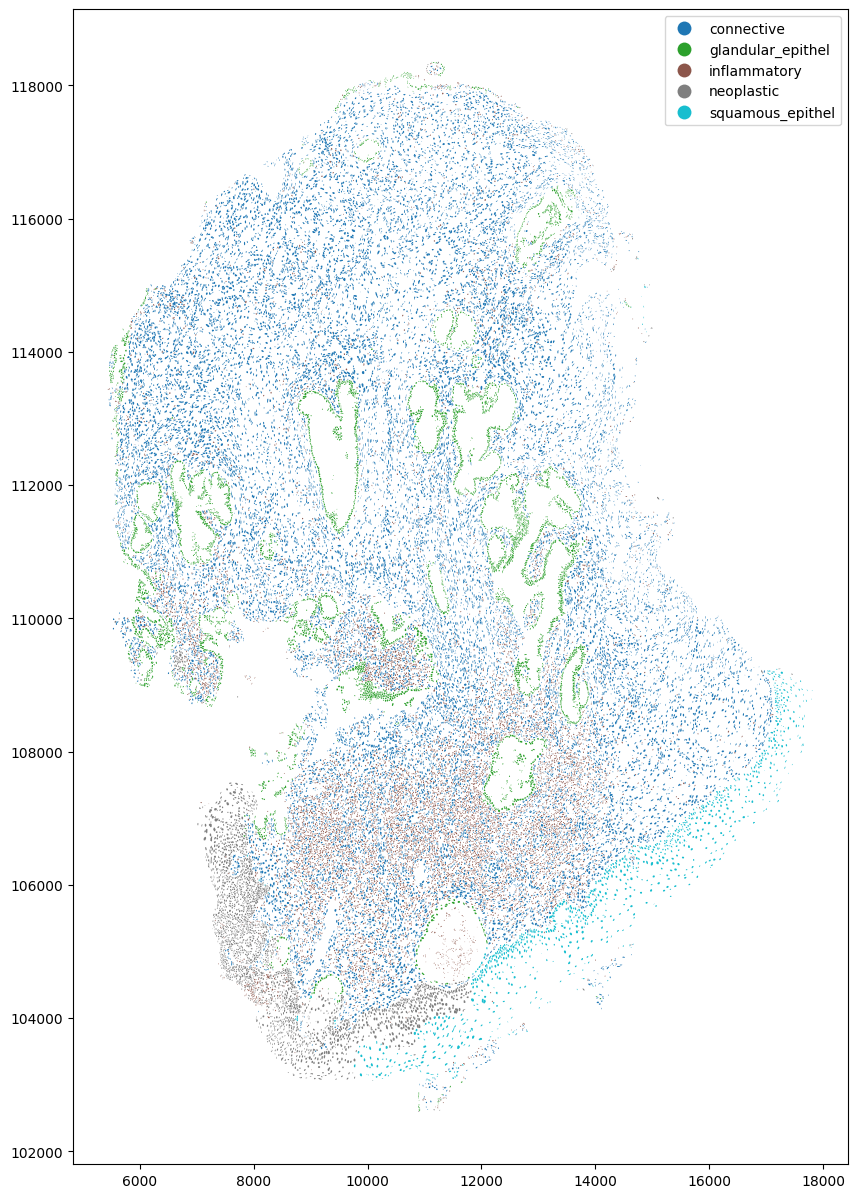

In [3]:
nuclei.plot(figsize=(10, 15), column="class_name", legend=True, aspect=None)

## Clustering Immune Cells

Yet again, we are interested in clustering immune cells. This is simple and `cellseg_gsontools` provides a simple function to do so. We will use the `cluster_points` function to cluster the cells in the nuclei segmentation mask. The `cluster_points` function is a wrapper for the DBSCAN related clustering algorithms from the `sklearn.cluster` module.
The allowed clustering algorithms are:

- DBSCAN
- OPTICS
- HDBSCAN
- ADBSCAN

We will be using the DBSCAN algorithm for this example. We will set the epsilon parameter to 120 (considers cells within 60 microns) and the minimum number of points to 20 (a cluster has to contain at least 20 points).

In [4]:
from cellseg_gsontools.clustering import cluster_points
import warnings
warnings.filterwarnings("ignore")

immune = nuclei.loc[nuclei["class_name"] == "inflammatory"]

# cluster the immune cells
immune = cluster_points(immune[["geometry"]], eps=120, min_samples=20, method="dbscan")
immune = immune.loc[immune["labels"] != -1] # rename noise points
immune.labels.value_counts()

labels
2     4814
1      333
15     330
0      134
16     132
7       86
6       82
10      74
3       70
4       35
17      34
11      32
14      32
12      27
9       26
8       25
13      20
5       13
Name: count, dtype: int64

<Axes: >

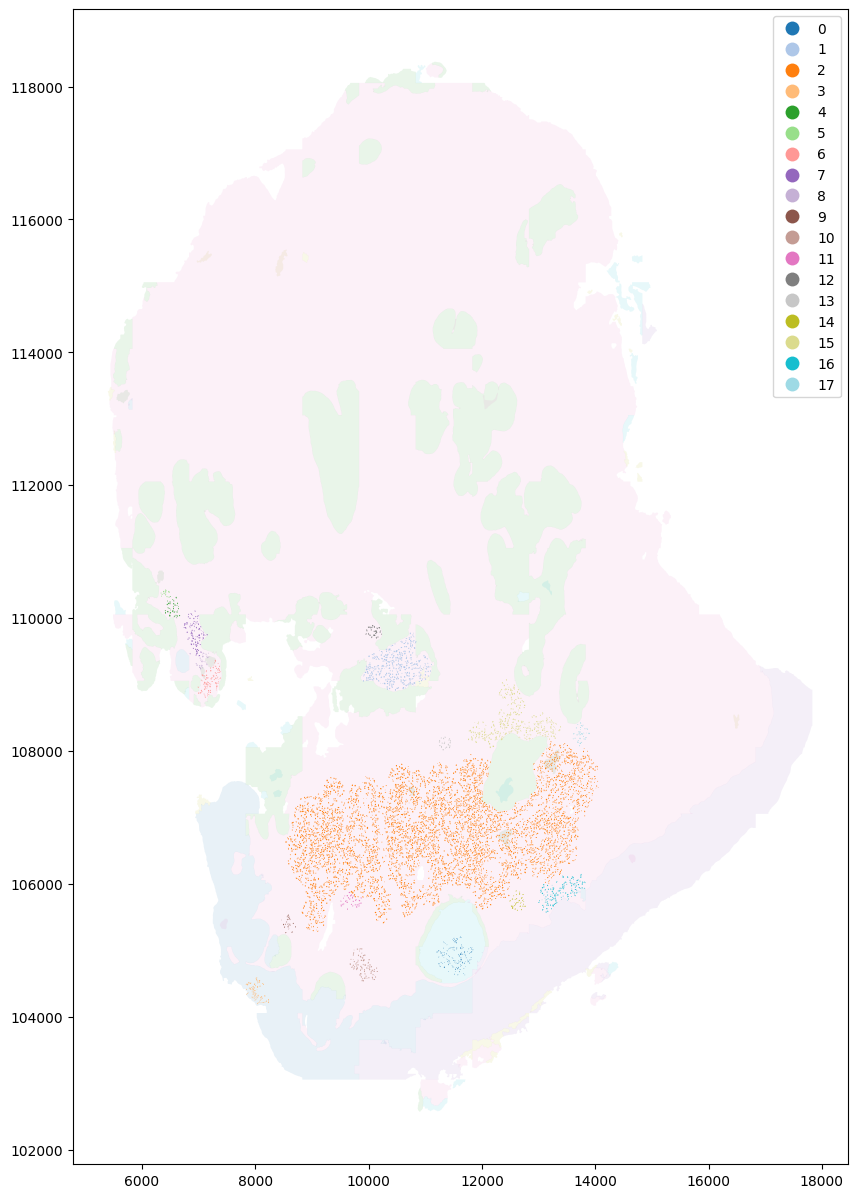

In [5]:
ax = tissues.plot(
    figsize=(10, 15),
    alpha=0.1,
    column="class_name",
    aspect=None
)
immune.plot(
    ax=ax,
    column="labels",
    categorical=True,
    cmap="tab20",
    legend=True,
    aspect=None
)

In the above plots you can see the immune cell clusters highlighted. There appears to be one major cluster and a number of smaller ones in this sample.

### Compute Cluster Dispersion

Next, we'll compute the dispersion of the clusters or the standard deviation of the distances between points in the cluster. The dispersion of the clusters is an indication of how tightly packed the clusters are. 

In [6]:
import shapely
import geopandas as gpd
import numpy as np

def get_dispersion(cells: gpd.GeoDataFrame):
    xy = np.vstack([cells.centroid.x, cells.centroid.y]).T
    n, p = xy.shape
    m = xy.mean(axis=0)
    return np.sqrt(((xy * xy).sum(axis=0) / n - m * m).sum())

cluster_std_distances = immune.groupby("labels").apply(
    lambda x: get_dispersion(x["geometry"])
)

cluster_std_distances

labels
0      211.546143
1      352.403063
2     1577.865794
3      137.323195
4      109.390956
5       58.157829
6      170.360235
7      187.765813
8       94.702071
9       83.982071
10     176.933932
11     124.720200
12      96.967663
13      85.344381
14     104.803038
15     451.613534
16     252.208297
17     110.009231
dtype: float64

From the results above we can see that the large cluster has a very large dispersion and the smaller clusters have a smaller dispersion. The cluster dispersion is typically heavily correlated with the cluster size. The larger the cluster, the larger the dispersion. It is a good indication of how wide the cluster Has spread.

### Compute Cluster Centroids

Next, we'll compute the mean centers of the clusters. These will be used to compute the distance between the cluster centroids and the lesions. We will plot them on top of the nuclei segmentation mask.

In [7]:
import shapely
import geopandas as gpd
import numpy as np

def get_mean_center(cells: gpd.GeoDataFrame):
    xy = np.vstack([cells.centroid.x, cells.centroid.y]).T
    return xy.mean(axis=0)


cluster_centroids = immune.groupby("labels").apply(
    lambda x: get_mean_center(x["geometry"])
)
data = []
for i, v in cluster_centroids.items():
    data.append([shapely.Point(v), i])

centroids = gpd.GeoDataFrame(data, columns=["geometry", "labels"])
centroids

,geometry,labels
0,POINT (11532.623 104915.359),0
1,POINT (10501.028 109281.822),1
2,POINT (11263.304 106775.933),2
3,POINT (8014.802 104356.890),3
4,POINT (6542.005 110150.184),4
5,POINT (6411.446 110370.355),5
6,POINT (7212.627 109052.086),6
7,POINT (6935.348 109777.326),7
8,POINT (7080.838 109361.423),8
9,POINT (8581.878 105405.632),9


<Axes: >

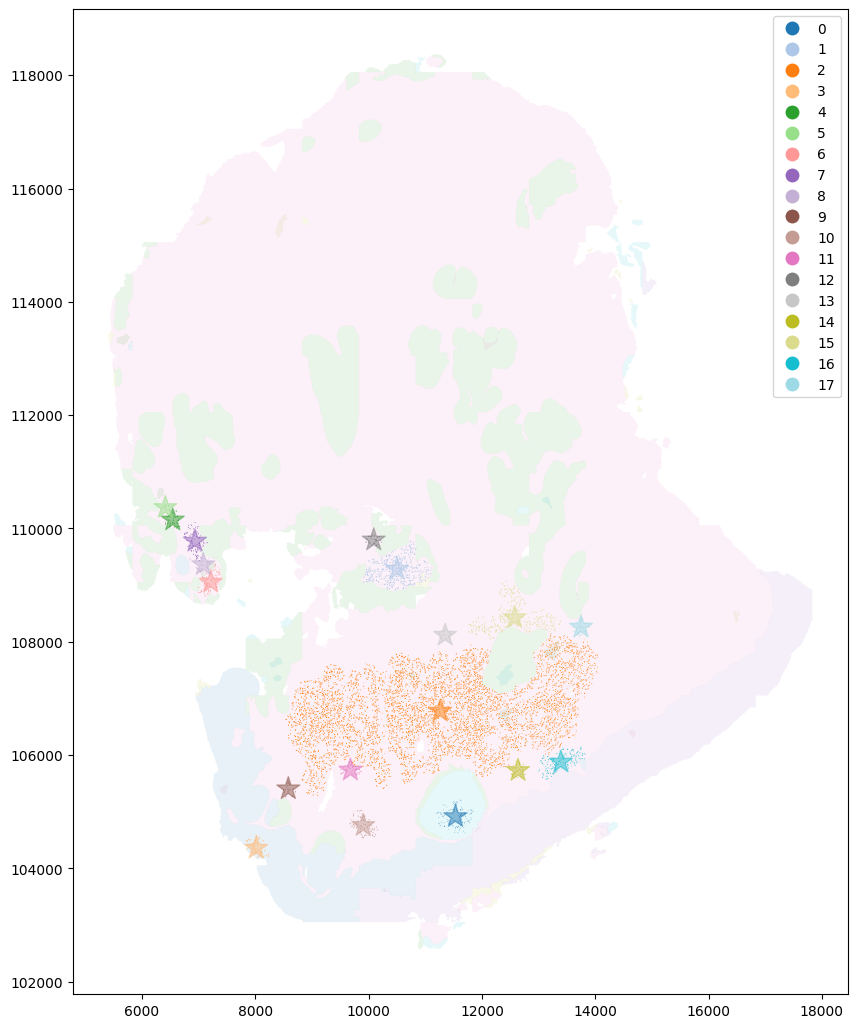

In [8]:
ax = tissues.plot(
    figsize=(10, 15),
    alpha=0.1,
    column="class_name",
    aspect=None
)
immune.plot(
    ax=ax,
    column="labels",
    categorical=True,
    cmap="tab20",
    legend=True,
    aspect=None
)
centroids.plot(
    ax=ax,
    cmap="tab20",
    markersize=300,
    marker="*",
    alpha=0.5
)

### Compute Distances to Different Tissues

Next we'll compute the distances between the cluster centroids and the tissues in the sample. We will also get the closest tissue per cluster and all the clusters that are within 250 microns from the lesion. 

In [9]:
import pandas as pd

# Helper function to get the distances of the cells to a given tissue class
def get_distances_to_tissue(objs, tissues, tissue_class):
    tissue = tissues.loc[tissues["class_name"] == tissue_class]

    distances = {}
    for i, poly in tissue.reset_index().iterrows():
        dist = objs.distance(poly.geometry)
        distances[i] = dist

    min_dists = pd.DataFrame(distances).min(axis=1)
    min_dists.name = f"distance_to_{tissue_class}"

    return objs.join(other=min_dists, how="left")

# get the distances to the tissue classes
centroids = get_distances_to_tissue(centroids, tissues, "area_cin")
centroids = get_distances_to_tissue(centroids, tissues, "areasquam")
centroids = get_distances_to_tissue(centroids, tissues, "areagland")

# get the clusters that are within 250 microns of the lesion
centroids["clust_within_250_micron_form_lesion"] = (
    centroids["distance_to_area_cin"] < 500
)

# get the closest tissue class
centroids["closest_tissue"] = (
    centroids[
        ["distance_to_area_cin", "distance_to_areasquam", "distance_to_areagland"]
    ]
    .idxmin(axis=1)
    .str.replace("distance_to_", "closest_to_")
)

# get the distance to the closest tissue class
centroids["distance_to_tissue"] = centroids[
    ["distance_to_area_cin", "distance_to_areasquam", "distance_to_areagland"]
].min(axis=1)

centroids.head(5)

,geometry,labels,distance_to_area_cin,distance_to_areasquam,distance_to_areagland,clust_within_250_micron_form_lesion,closest_tissue,distance_to_tissue
0,POINT (11532.623 104915.359),0,420.999237,358.591268,429.959676,True,closest_to_areasquam,358.591268
1,POINT (10501.028 109281.822),1,3133.244304,4498.854424,313.917045,False,closest_to_areagland,313.917045
2,POINT (11263.304 106775.933),2,2235.382378,1888.740965,711.974376,False,closest_to_areagland,711.974376
3,POINT (8014.802 104356.890),3,0.000000,1947.313708,454.891400,True,closest_to_area_cin,0.000000
4,POINT (6542.005 110150.184),4,635.961553,7283.810143,125.302327,False,closest_to_areagland,125.302327


Let's now plot the diastances. We will bin the distance values with the Fisher-Jenks method in the plot.

<Axes: >

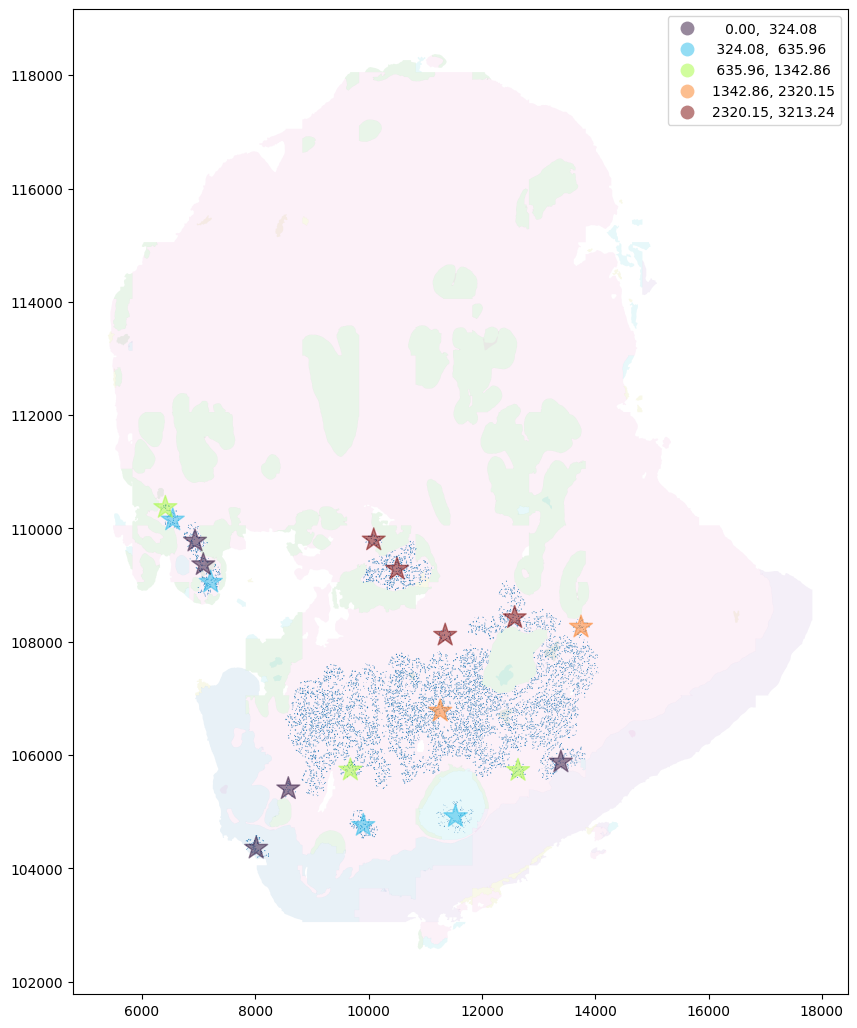

In [10]:
ax = tissues.plot(
    figsize=(10, 15),
    alpha=0.1,
    column="class_name",
    aspect=None
)
immune.plot(
    ax=ax,
    legend=False,
    aspect=None
)
centroids.plot(
    ax=ax,
    column="distance_to_area_cin",
    cmap="turbo",
    legend=True,
    categorical=True,
    scheme="fisherjenks",
    markersize=300,
    marker="*",
    alpha=0.5
)

Let's plot which clusters are within 250 microns from the lesion.

<Axes: >

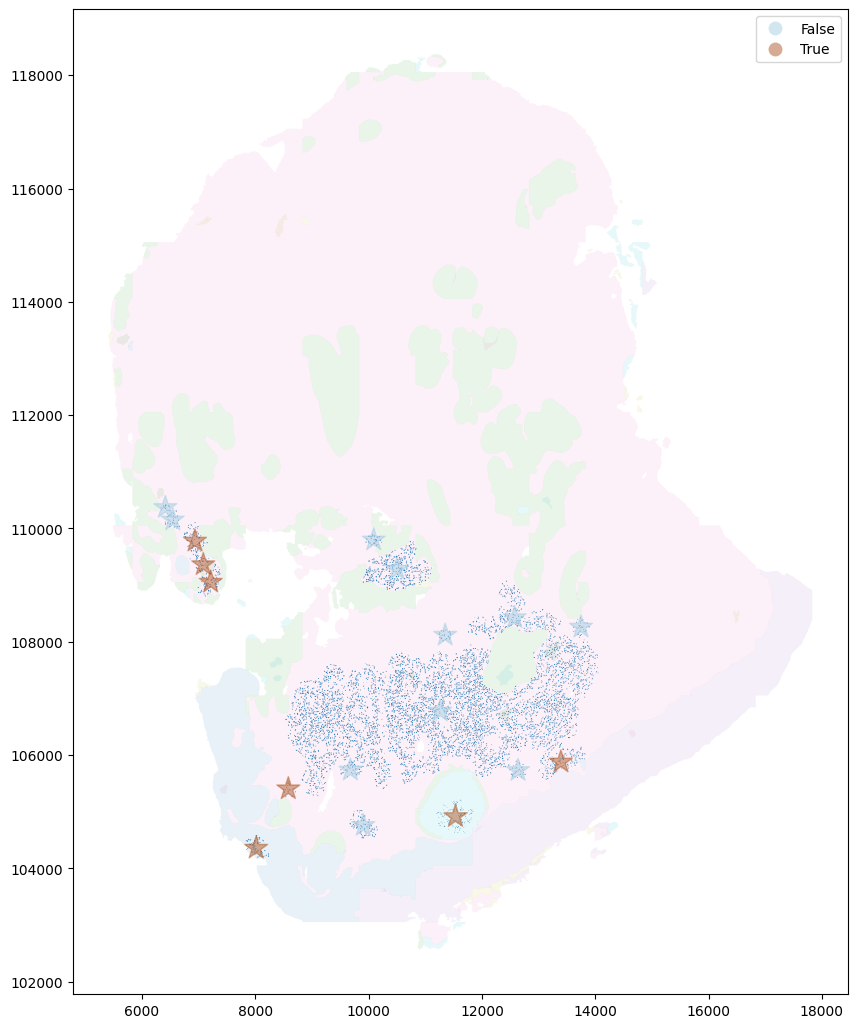

In [11]:
ax = tissues.plot(
    figsize=(10, 15),
    alpha=0.1,
    column="class_name",
    aspect=None
)
immune.plot(
    ax=ax,
    legend=False,
    aspect=None
)
centroids.plot(
    ax=ax,
    column="clust_within_250_micron_form_lesion",
    cmap="Paired",
    legend=True,
    categorical=True,
    markersize=300,
    marker="*",
    alpha=0.5
)

We can see from the plot that we have only small clusters residing less than 250 microns from the lesion (when computed from the centroid). Let's now plot the closest tissue per cluster.

<Axes: >

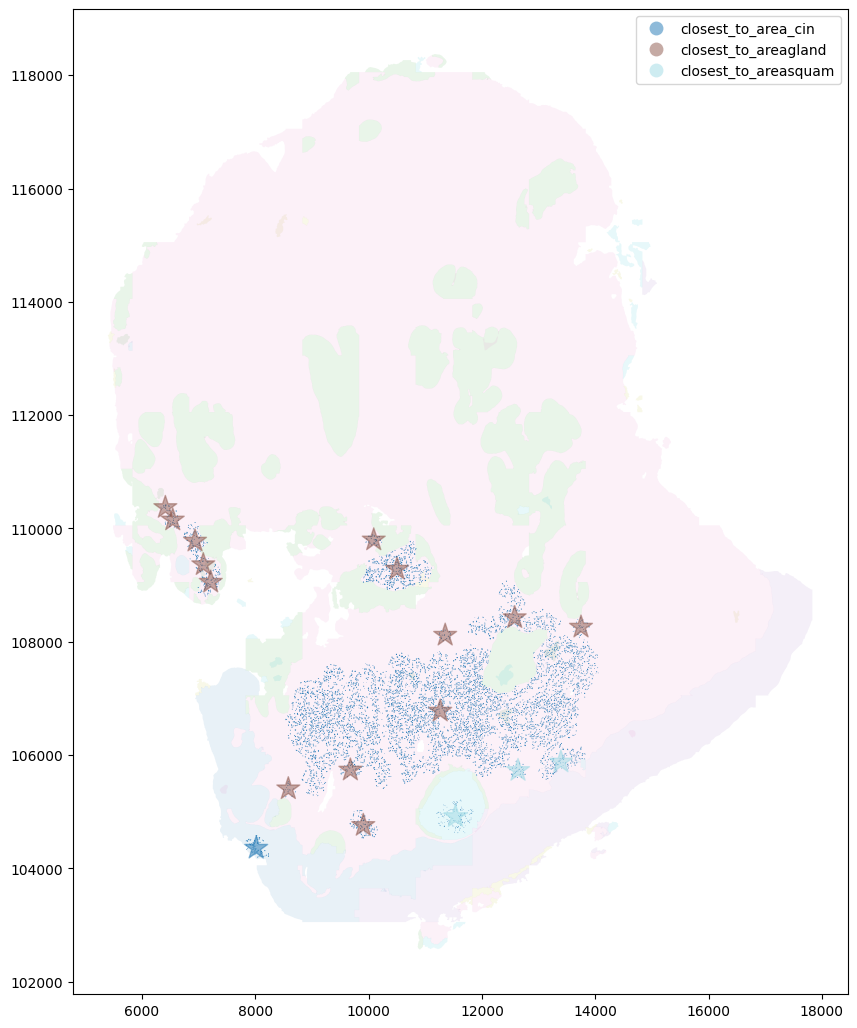

In [12]:
ax = tissues.plot(
    figsize=(10, 15),
    alpha=0.1,
    column="class_name",
    aspect=None
)
immune.plot(
    ax=ax,
    legend=False,
    aspect=None
)
centroids.plot(
    ax=ax,
    column="closest_tissue",
    cmap="tab20",
    legend=True,
    categorical=True,
    markersize=300,
    marker="*",
    alpha=0.5
)

There is only one cluster centroid that is closest to the lesion, although, we can clearly tell that part of the big cluster is located closer to the lesion than any other tissues. This is a problem with measuring distance from the centroid since if a cluster is very large the centroid of the cluster can be located far away from the tissues of interest. Let's rather plot the distances between the clustered cells and the tissues to see the difference.

In [13]:
# get the distances to the tissue classes
immune = get_distances_to_tissue(immune, tissues, "area_cin")
immune = get_distances_to_tissue(immune, tissues, "areasquam")
immune = get_distances_to_tissue(immune, tissues, "areagland")

# get the closest tissue class
immune["closest_tissue"] = (
    immune[
        ["distance_to_area_cin", "distance_to_areasquam", "distance_to_areagland"]
    ]
    .idxmin(axis=1)
    .str.replace("distance_to_", "closest_to_")
)

immune.head(5)

,geometry,labels,distance_to_area_cin,distance_to_areasquam,distance_to_areagland,closest_tissue
310,"POLYGON ((6990.00000 108951.02000, 6984.01000 ...",6,292.849898,6008.916691,0.0,closest_to_areagland
342,"POLYGON ((7144.00000 109740.02000, 7140.01000 ...",7,438.542862,6650.941868,0.0,closest_to_areagland
947,"POLYGON ((10332.25000 108920.00000, 10328.8300...",1,2779.557095,4223.818837,0.0,closest_to_areagland
948,"POLYGON ((10739.00000 109002.02000, 10737.0100...",1,3165.189791,4152.713902,0.0,closest_to_areagland
971,"POLYGON ((9964.00000 109266.02000, 9961.01000 ...",1,2716.858126,4693.418744,0.0,closest_to_areagland


<Axes: >

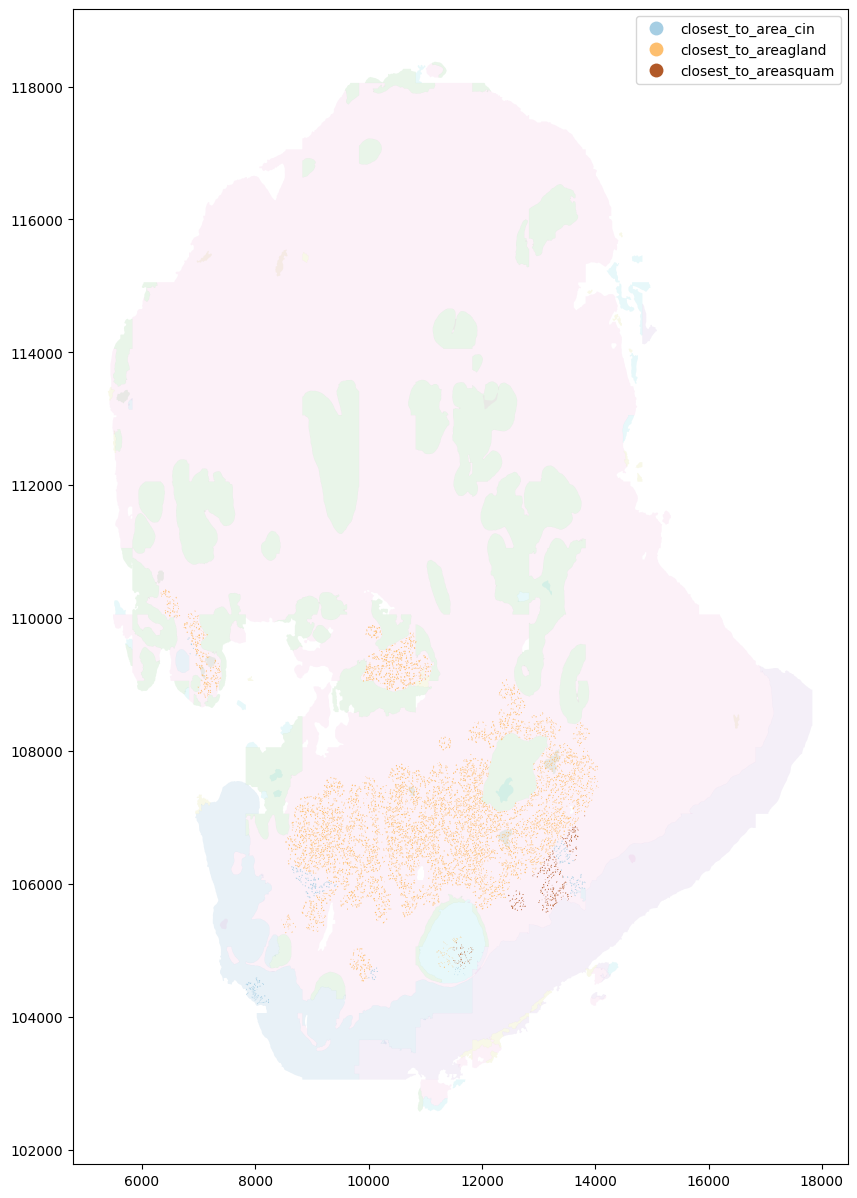

In [14]:
ax = tissues.plot(
    figsize=(10, 15),
    alpha=0.1,
    column="class_name",
    aspect=None
)
immune.plot(
    ax=ax,
    column="closest_tissue",
    legend=True,
    cmap="Paired",
    categorical=True,
    aspect=None
)

The results didn't change much, but now we see that some of the cells belonging to the big cluster are actually closer to the lesion than other tissues.